### Note: This file is for presentational purpouses only. Its cells will not work if downloaded from gihub and ran

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
%matplotlib inline

import sys
sys.path.append('./Amazing-Semantic-Segmentation')
from models.network import Network
from models.fcn import FCN
from models.pspnet import PSPNet
from models.segnet import SegNet
from models.unet import UNet
from models.pan import PAN
from models.deeplab_v3 import DeepLabV3
from models.deeplab_v3_plus import DeepLabV3Plus
from models.refinenet import RefineNet
from models.denseaspp import DenseASPP
from models.bisegnet import BiSegNet
from utils.utils import *
from utils.callbacks import *
from utils.data_generator import *
from utils.layers import *
from utils.learning_rate import *
from utils.losses import *
from utils.optimizers import *
from utils.metrics import *
from utils.helpers import *
layers = tf.keras.layers

# Pix2Pix model results

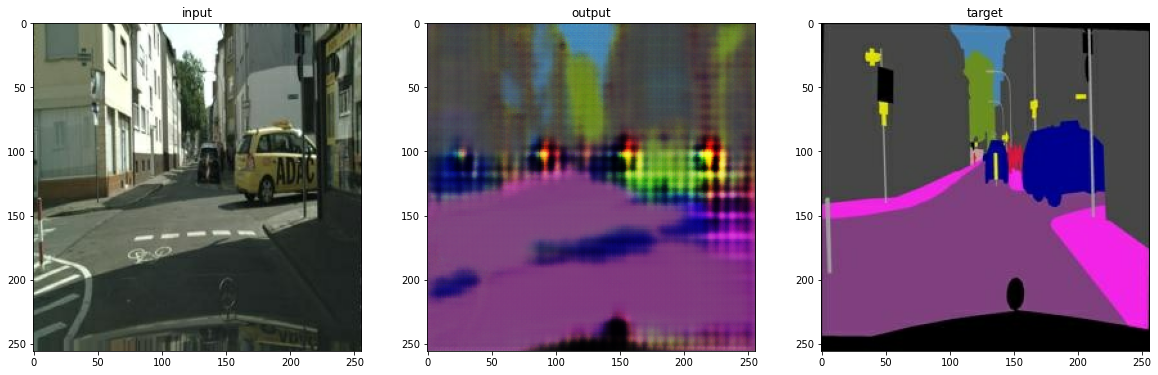

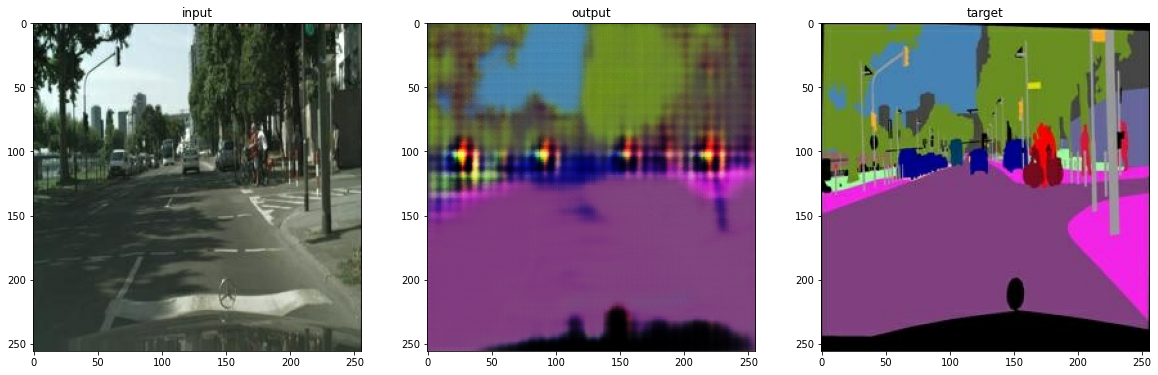

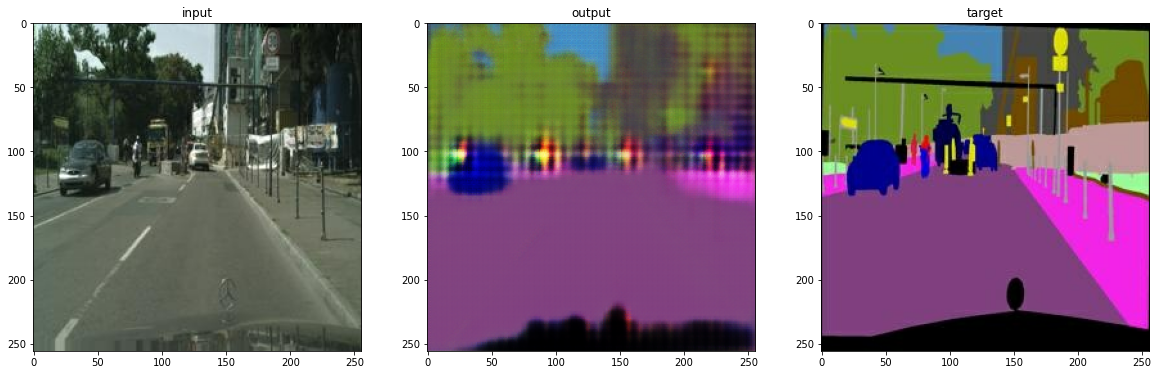

In [5]:
os.chdir('pix2pix-tensorflow/cityscapes_test/images/')
example_imgs = os.listdir('./')

inputs, outputs, targets = [], [], []
for img in example_imgs:
    if img.endswith('inputs.png'):
        inputs.append(img)    
    if img.endswith('outputs.png'):
        outputs.append(img)
    if img.endswith('targets.png'):
        targets.append(img)
inputs.sort()
outputs.sort()
targets.sort()

for i, o, t in zip(inputs[:3], outputs[:3], targets[:3]):
    fig = plt.figure(figsize=(20,10))
    fig.subplots(1,3)
    plt.subplot(131)
    tmp_img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    plt.imshow(tmp_img)
    plt.title('input')
    plt.subplot(132)
    tmp_img = cv2.cvtColor(cv2.imread(o), cv2.COLOR_BGR2RGB)
    plt.imshow(tmp_img)
    plt.title('output')
    plt.subplot(133)
    tmp_img = cv2.cvtColor(cv2.imread(t), cv2.COLOR_BGR2RGB)
    plt.imshow(tmp_img)
    plt.title('target')
plt.show()

# SegNet model results

In [6]:
# predict function

def predict_image(model, image_path, dataset, num_classes, color_encoded=True,
                  target_size=(256,256), base_model=None):
    """
    Function which tests the provided model on only one image
    Parameters:
    model: the model built by the builder function which you want to use, tf.Model
    image_path: the path of the image to be segmented, str
    dataset: path to the dataset, str
    num_classes: number of classes in the dataset, int
    color_encoded: whether to color encode the resulting segmented image according to the class_dict file
    base_model: the base model, string or None
    """

    # check the image path in drive
    if not os.path.exists(image_path):
        raise ValueError('The path \'{}\' does not exist the image file.'.format(image_path))

    if base_model is None:
        base_model='VGG16'
    # begin testing
    print("\n***** Begin testing *****")
    print("Model -->", model)
    print("Base Model -->", base_model)
    print("Num Classes -->", num_classes)
    print("")

    # load_images
    image_names=list()
    if os.path.isfile(image_path):
        image_names.append(image_path)
    else:
        for f in os.listdir(image_path):
            image_names.append(os.path.join(image_path, f))
        image_names.sort()

   
    csv_color_file = os.path.join(dataset, 'class_dict.csv')
    _, color_values = get_colored_info(csv_color_file)

    for i, name in enumerate(image_names):
        sys.stdout.write('\rRunning test image %d / %d'%(i+1, len(image_names)))
        sys.stdout.flush()

        image = cv2.resize(load_image(name),
                          dsize=target_size)
        image = imagenet_utils.preprocess_input(image.astype(np.float32),
                                                data_format='channels_last', mode='torch')

        # image processing
        if np.ndim(image) == 3:
            image = np.expand_dims(image, axis=0)
        assert np.ndim(image) == 4

        # get the prediction
        prediction = model.predict(image)

        if np.ndim(prediction) == 4:
            prediction = np.squeeze(prediction, axis=0)

        # decode one-hot
        prediction = decode_one_hot(prediction)

        # color encode
        if color_encoded:
            prediction = color_encode(prediction, color_values)

        # get PIL file
        prediction = Image.fromarray(np.uint8(prediction))

        # save the prediction to drive
        # _, file_name = os.path.split(name)
        # prediction.save(os.path.join(paths['prediction_path'], file_name))
        return prediction

## On CamVid dataset

In [15]:
os.chdir('../../../Amazing-Semantic-Segmentation')

# load the model
from tensorflow.keras.models import load_model

model = load_model('../SegNet_VGG16base_CamVid_20epochs.h5', compile=False)
model.compile(
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
loss = categorical_crossentropy_with_logits,
metrics = [MeanIoU(32)])


***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x7efc50137250>
Base Model --> VGG16
Num Classes --> 32

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x7efc50137250>
Base Model --> VGG16
Num Classes --> 32

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x7efc50137250>
Base Model --> VGG16
Num Classes --> 32

Running test image 1 / 1

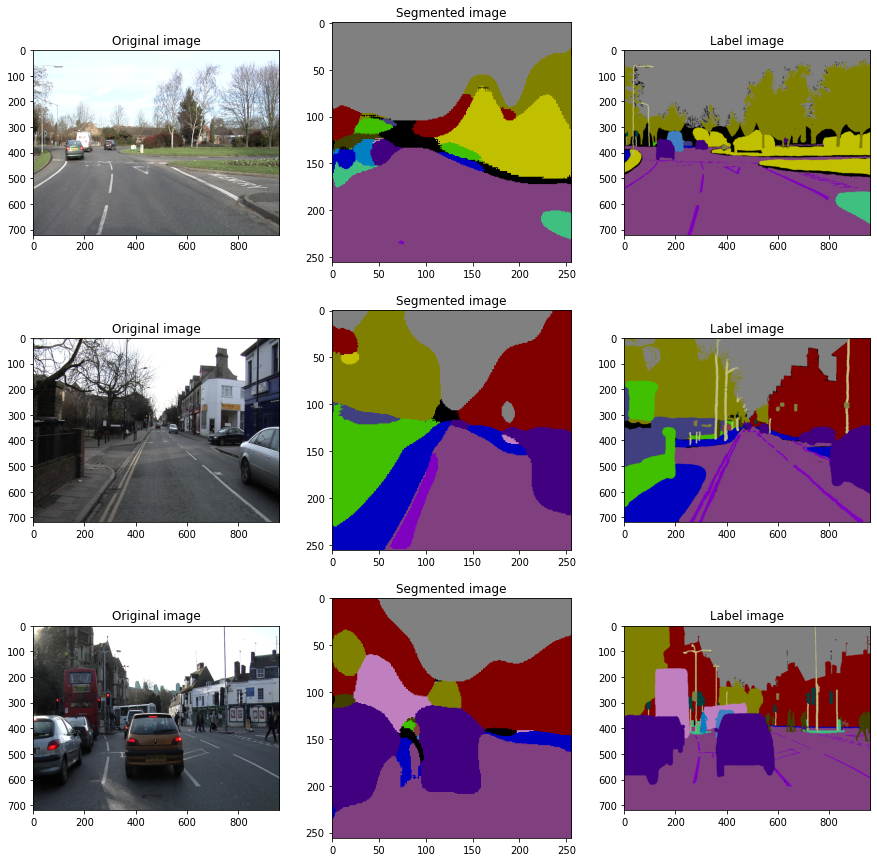

In [16]:
import pandas as pd
class_dict = pd.read_csv('./CamVid/class_dict.csv')
imgs, lbls, prds = [], [], []
files = ['0006R0_f01020', 'Seq05VD_f01410', '0016E5_04470']
for f in files:
    imgs.append(cv2.cvtColor(cv2.imread('./CamVid/test/images/' + f + '.png'),
                       cv2.COLOR_BGR2RGB))
    lbl_gray = cv2.imread('./CamVid/test/labels/' + f + '_L.png', 0)
    lbl_color = [[[class_dict['r'].iloc[y], class_dict['g'].iloc[y],
                            class_dict['b'].iloc[y]] for y in x] for x in lbl_gray]
    lbls.append(lbl_color)
    prds.append(predict_image(model, './CamVid/test/images/' + f + '.png',
                         './CamVid', num_classes=32, target_size=(256, 256)))

fig = plt.figure(figsize=(15,15))
fig.subplots(3,3)

for i in range(len(imgs)):
    plt.subplot(3,3,3*i+1)
    plt.title('Original image')
    plt.imshow(imgs[i])

    plt.subplot(3,3,3*i+2)
    plt.title('Segmented image')
    plt.imshow(prds[i])

    plt.subplot(3,3,3*i+3)
    plt.title('Label image')
    plt.imshow(lbls[i])

plt.show()

## On MSRC dataset

In [17]:
# load the model
model = load_model('../SegNet_VGG16base_MSRC_25epochs.h5', compile=False)
model.compile(
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
loss = categorical_crossentropy_with_logits,
metrics = [MeanIoU(14)])


***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x7efbcb8db8d0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x7efbcb8db8d0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x7efbcb8db8d0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1

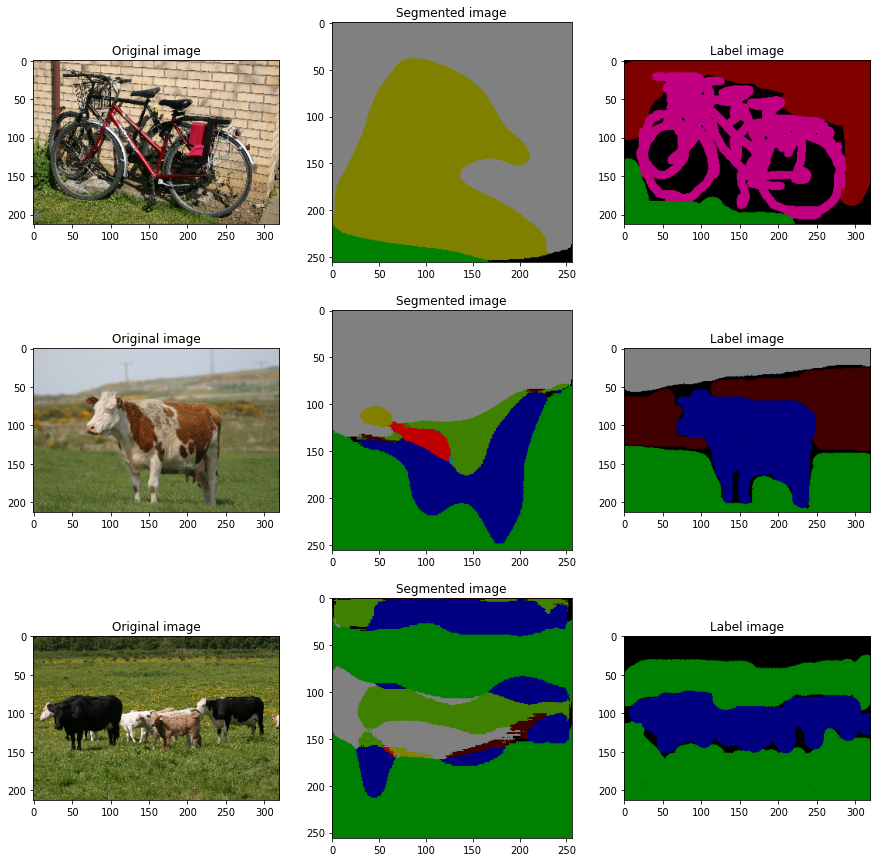

In [19]:
imgs, lbls, prds = [], [], []
class_dict = pd.read_csv('./MSRC_Dataset/class_dict.csv')
files = ['8_3_s', '5_30_s', '1_8_s']
for f in files:
    imgs.append(cv2.cvtColor(cv2.imread('./MSRC_Dataset/test/images/' + f + '.png'),
                       cv2.COLOR_BGR2RGB))
    lbl_gray = cv2.imread('./MSRC_Dataset/test/labels/' + f + '_L.png', 0)
    lbl_color = [[[class_dict['r'].iloc[y], class_dict['g'].iloc[y],
                            class_dict['b'].iloc[y]] for y in x] for x in lbl_gray]
    lbls.append(lbl_color)
    prds.append(predict_image(model, './MSRC_Dataset/test/images/' + f + '.png',
                         './MSRC_Dataset', num_classes=14, target_size=(256, 256)))

fig = plt.figure(figsize=(15,15))
fig.subplots(3,3)

for i in range(len(imgs)):
    plt.subplot(3,3,3*i+1)
    plt.title('Original image')
    plt.imshow(imgs[i])

    plt.subplot(3,3,3*i+2)
    plt.title('Segmented image')
    plt.imshow(prds[i])

    plt.subplot(3,3,3*i+3)
    plt.title('Label image')
    plt.imshow(lbls[i])

plt.show()

# DeepLabV3 model results

## On CamVid dataset

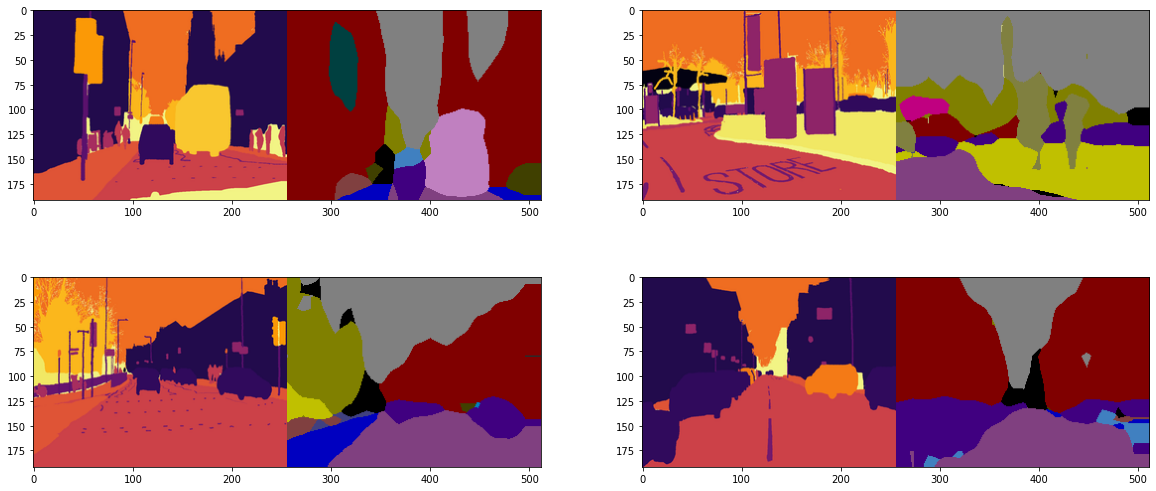

In [22]:
files = ['0001TP_006750.png', '0006R0_f01860.png', '0016E5_01440.png', '0016E5_06330.png']
fig = plt.figure(figsize=(20, 9))
fig.subplots(2,2)
for i in range(len(files)):
    plt.subplot(2,2,i+1)
    img = cv2.cvtColor(cv2.imread('../DeepLab_CamVid_16_epochs_results/' + files[i]), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

## On MSRC dataset

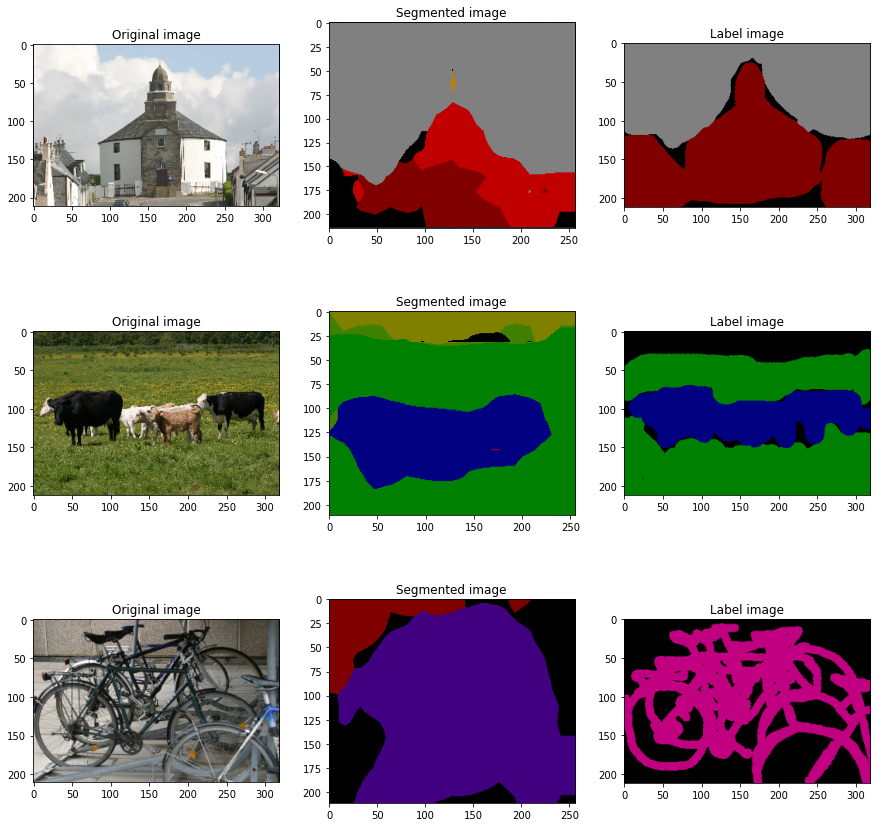

In [24]:
imgs, lbls, prds = [], [], []
class_dict = pd.read_csv('./MSRC_Dataset/class_dict.csv')
for i in range(3):
    imgs.append(cv2.cvtColor(cv2.imread('./MSRC_Dataset/to_show/' + str(3*i + 1) + '.png'),
                       cv2.COLOR_BGR2RGB))
    lbl_gray = cv2.imread('./MSRC_Dataset/to_show/' + str(3*i + 2) + '.png', 0)
    lbl_color = [[[class_dict['r'].iloc[y], class_dict['g'].iloc[y],
                            class_dict['b'].iloc[y]] for y in x] for x in lbl_gray]
    lbls.append(lbl_color)
    prds.append(cv2.cvtColor(cv2.imread('./MSRC_Dataset/to_show/' + str(3*i + 3) + '.png'), cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(15,15))
fig.subplots(3,3)

for i in range(len(imgs)):
    plt.subplot(3,3,3*i+1)
    plt.title('Original image')
    plt.imshow(imgs[i])

    plt.subplot(3,3,3*i+2)
    plt.title('Segmented image')
    plt.imshow(prds[i])

    plt.subplot(3,3,3*i+3)
    plt.title('Label image')
    plt.imshow(lbls[i])

plt.show()